# Data Analysis

## Data Loading

In [82]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_processing import load_train_and_test_data

train_data, test_data = load_train_and_test_data()

## Data Inspection

### Counting Instances

#### Training Set

In [83]:
instances_count = train_data.shape[0]
print(f"Instances: {instances_count}")

Instances: 10886


#### Test Set

In [84]:
instances_count = test_data.shape[0]
print(f"Instances: {instances_count}")

Instances: 6493


### Sampling Dataset

#### Training Set

In [85]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### Test Set

In [86]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Checking Feature and Target Variable Data Types

In [87]:
import pandas as pd

data_types = train_data.dtypes
pd.DataFrame(data_types, columns=['Type'])

,Type
datetime,datetime64[ns]
season,int64
holiday,int64
workingday,int64
weather,int64
temp,float64
atemp,float64
humidity,int64
windspeed,float64
casual,int64


## Data Cleaning and Preprocessing

### Handling Missing Values

#### Training Set

In [88]:
missing_values = train_data.isnull().sum()
pd.DataFrame(missing_values, columns=["Count"])

,Count
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0
casual,0


#### Test Set

In [89]:
missing_values = test_data.isnull().sum()
pd.DataFrame(missing_values, columns=["Count"])

,Count
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0


### Handling Duplicate Rows

#### Training Set

In [90]:
duplicates_count = train_data.duplicated().sum()
print(f"Duplicate rows: {duplicates_count}")

Duplicate rows: 0


#### Test Set

In [91]:
duplicates_count = test_data.duplicated().sum()
print(f"Duplicate rows: {duplicates_count}")

Duplicate rows: 0


### Adjusting Data Types

In [92]:
from data_processing import convert_datetime_to_timestamp

train_data_converted = convert_datetime_to_timestamp(train_data)
train_data_converted[["datetime"]].head()

,datetime
0,359400
1,359401
2,359402
3,359403
4,359404


In [93]:
unique_values = train_data.nunique()
pd.DataFrame(unique_values, columns=["Unique Values Count"])

,Unique Values Count
datetime,10886
season,4
holiday,2
workingday,2
weather,4
temp,49
atemp,60
humidity,89
windspeed,28
casual,309


In [94]:
from data_processing import perform_categorical_conversion

train_data_processed = perform_categorical_conversion(train_data_converted)
data_types_after_processing = train_data_processed.dtypes
pd.DataFrame(data_types_after_processing, columns=["Type"])

,Type
datetime,int64
season,category
holiday,category
workingday,category
weather,category
temp,float64
atemp,float64
humidity,int64
windspeed,float64
casual,int64


## Exploratory Data Analysis (EDA)

### Univariate Analysis of Numerical Features

#### Summary Statistics

In [95]:
from config import TARGET_VARIABLES

numerical = train_data_processed.select_dtypes(
    include=['float64', 'int64']).drop(columns=TARGET_VARIABLES).columns

def calculate_numerical_statistics(columns, data):
    basic_stats = data[columns].describe()
    extended_stats = basic_stats.T
    
    extended_stats['median'] = data[columns].median()
    extended_stats['variance'] = data[columns].var()
    extended_stats['range'] = data[columns].max() - \
        data[columns].min()
    extended_stats['iqr'] = data[columns].quantile(
        0.75) - data[columns].quantile(0.25)
    extended_stats['skewness'] = data[columns].skew()
    extended_stats['kurtosis'] = data[columns].kurtosis()
    
    return extended_stats


calculate_numerical_statistics(numerical, train_data_processed)

,count,mean,std,min,25%,50%,75%,max,median,variance,range,iqr,skewness,kurtosis
datetime,10886.0,368045.939555,5052.135948,359400.00,363775.2500,368180.500,372540.7500,376655.0000,368180.500,2.552408e+07,17255.0000,8765.5000,-0.000989,-1.202427
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000,20.500,6.070887e+01,40.1800,12.3000,0.003691,-0.914530
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550,24.240,7.181886e+01,44.6950,14.3950,-0.102560,-0.850076
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000,62.000,3.703713e+02,100.0000,30.0000,-0.086335,-0.759818
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969,12.998,6.665967e+01,56.9969,9.9964,0.588767,0.630133


#### Distributions

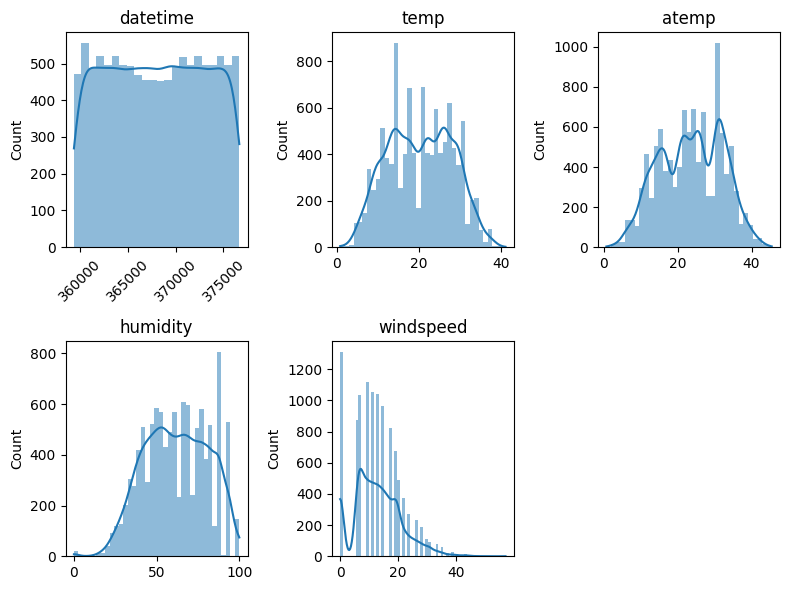

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_subplots_layout(columns):
    num_features = len(columns)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols
    
    return num_rows, num_cols

def rotate_xticklabels_if_long(ax, label_length_threshold=5, rotation_angle=45):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    if any(len(label) > label_length_threshold for label in labels):
        ax.tick_params(axis='x', labelrotation=rotation_angle)

def plot_numerical_distributions(columns, data):
    num_rows, num_cols = calculate_subplots_layout(columns)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3*num_rows))
    axes = axes.flatten()

    for i, feature in enumerate(columns):
        sns.histplot(data[feature], ax=axes[i], kde=True, edgecolor=None)
        axes[i].set_title(feature)
        axes[i].set_xlabel('')
        rotate_xticklabels_if_long(axes[i])

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


plot_numerical_distributions(numerical, train_data_processed)

#### Outliers

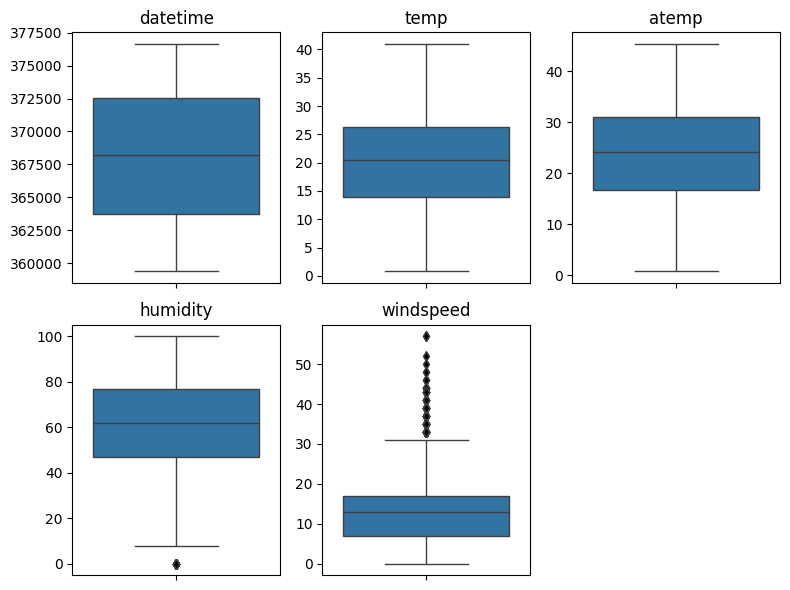

In [97]:
def plot_numerical_outliers(columns, data):
    flierprops = dict(marker='d', markerfacecolor='black', markersize=5)

    num_rows, num_cols = calculate_subplots_layout(columns)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3*num_rows))
    axes = axes.flatten()

    for i, feature in enumerate(columns):
        sns.boxplot(data=data, y=feature, ax=axes[i], flierprops=flierprops)
        axes[i].set_title(feature)
        axes[i].set_ylabel('')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_numerical_outliers(numerical, train_data_processed)

##### Windspeed Outlier Investigation

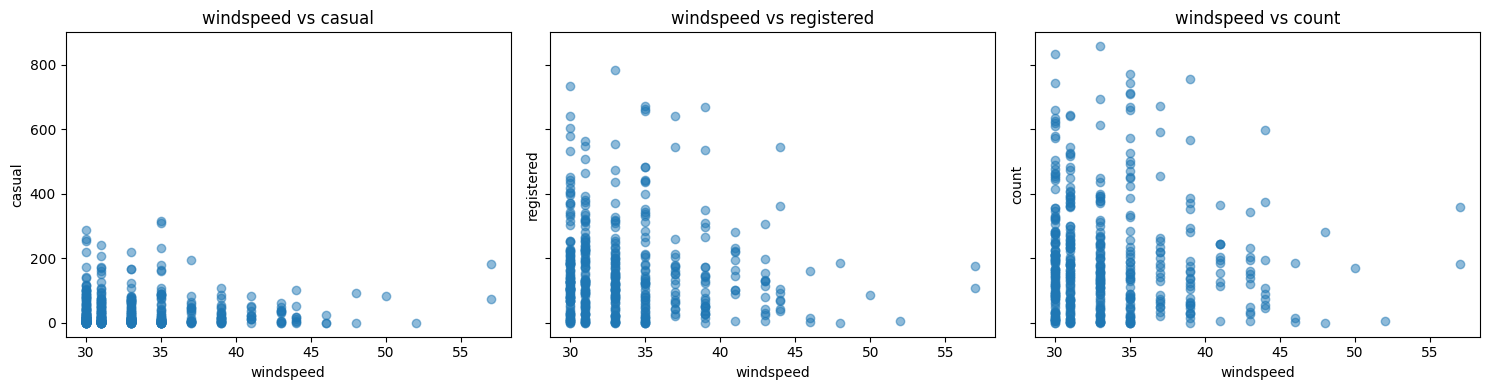

In [98]:
def plot_outliers_vs_targets(outlier_feature, data):
    upper_bound = data[outlier_feature].quantile(0.95)
    outliers = data[data[outlier_feature] > upper_bound]

    num_targets = len(TARGET_VARIABLES)
    
    fig, axes = plt.subplots(1, num_targets, figsize=(5 * num_targets, 4), sharey=True)

    for i, target in enumerate(TARGET_VARIABLES):
        ax = axes[i]
        ax.scatter(outliers[outlier_feature], outliers[target], alpha=0.5)
        ax.set_xlabel(outlier_feature)
        ax.set_ylabel(target)
        ax.set_title(f'{outlier_feature} vs {target}')
    
    plt.tight_layout()
    plt.show()

plot_outliers_vs_targets('windspeed', train_data_processed)

### Univariate Analysis of Categorical Features

#### Summary Statistics

In [99]:
categorical = train_data_processed.select_dtypes(
    include=['category']).columns

train_data_processed[categorical].describe()

,season,holiday,workingday,weather
count,10886,10886,10886,10886
unique,4,2,2,4
top,4,0,1,1
freq,2734,10575,7412,7192


#### Distributions

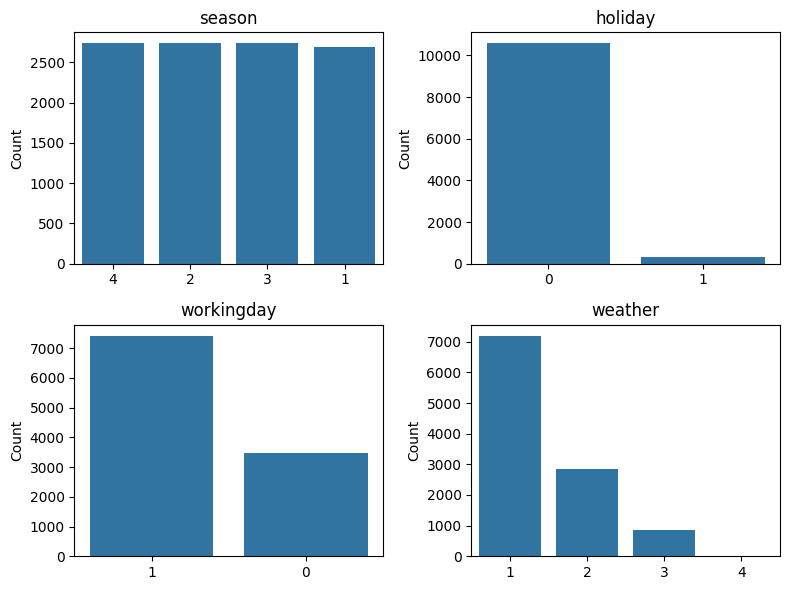

In [100]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(categorical):
    sns.countplot(data=train_data_processed, x=col,
                  ax=axes[i], order=train_data_processed[col].value_counts().index)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Univariate Analysis of Target Variables

#### Summary Statistics

In [101]:
calculate_numerical_statistics(TARGET_VARIABLES, train_data_processed)

,count,mean,std,min,25%,50%,75%,max,median,variance,range,iqr,skewness,kurtosis
casual,10886.0,36.021955,49.960477,0.0,4.0,17.0,49.0,367.0,17.0,2496.049219,367,45.0,2.495748,7.551629
registered,10886.0,155.552177,151.039033,0.0,36.0,118.0,222.0,886.0,118.0,22812.789514,886,186.0,1.524805,2.626081
count,10886.0,191.574132,181.144454,1.0,42.0,145.0,284.0,977.0,145.0,32813.313153,976,242.0,1.242066,1.300093


#### Transform Data

In [102]:
from data_processing import transform_target_variable_data

train_data_transformed = transform_target_variable_data(train_data_processed)
calculate_numerical_statistics(TARGET_VARIABLES, train_data_transformed)

,count,mean,std,min,25%,50%,75%,max,median,variance,range,iqr,skewness,kurtosis
casual,10886.0,2.712439,1.491055,0.000000,1.609438,2.890372,3.912023,5.908083,2.890372,2.223245,5.908083,2.302585,-0.224723,-0.869697
registered,10886.0,4.395774,1.399383,0.000000,3.610918,4.779123,5.407172,6.787845,4.779123,1.958273,6.787845,1.796254,-0.855562,-0.069953
count,10886.0,4.591364,1.419454,0.693147,3.761200,4.983607,5.652489,6.885510,4.983607,2.014850,6.192362,1.891289,-0.851412,-0.119483


#### Distributions

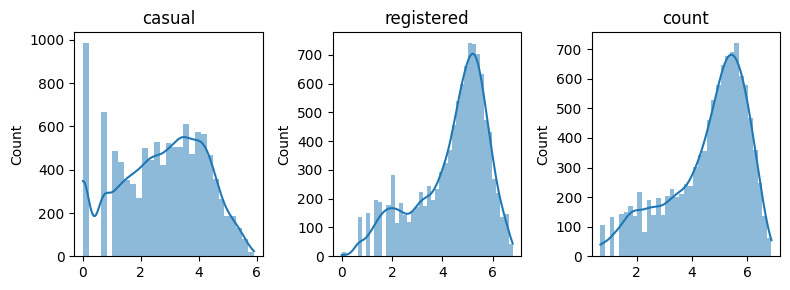

In [103]:
plot_numerical_distributions(TARGET_VARIABLES, train_data_transformed)

#### Outliers

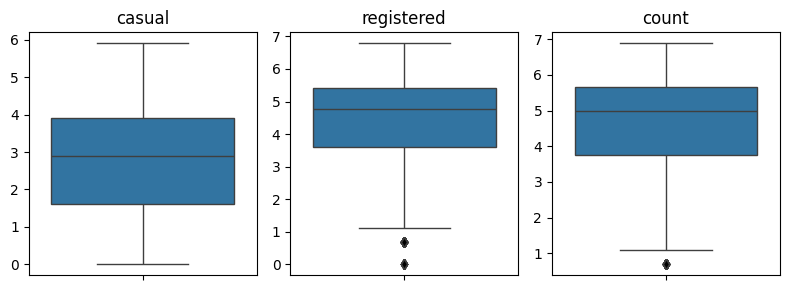

In [104]:
plot_numerical_outliers(TARGET_VARIABLES, train_data_transformed)

### Bivariate Analysis of Numerical - Numerical Features

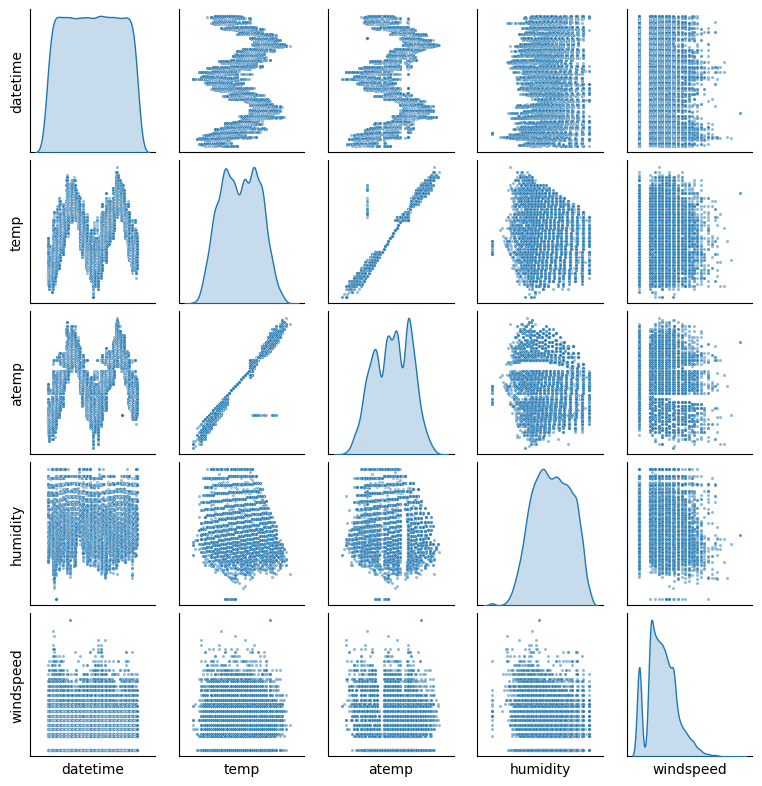

In [105]:
pairplot = sns.pairplot(train_data_transformed[numerical], plot_kws={'s': 5, 'alpha': 0.5},
             diag_kind='kde')

pairplot.figure.set_size_inches(8, 8)

for ax in pairplot.axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Bivariate Analysis of Numerical - Categorical Features

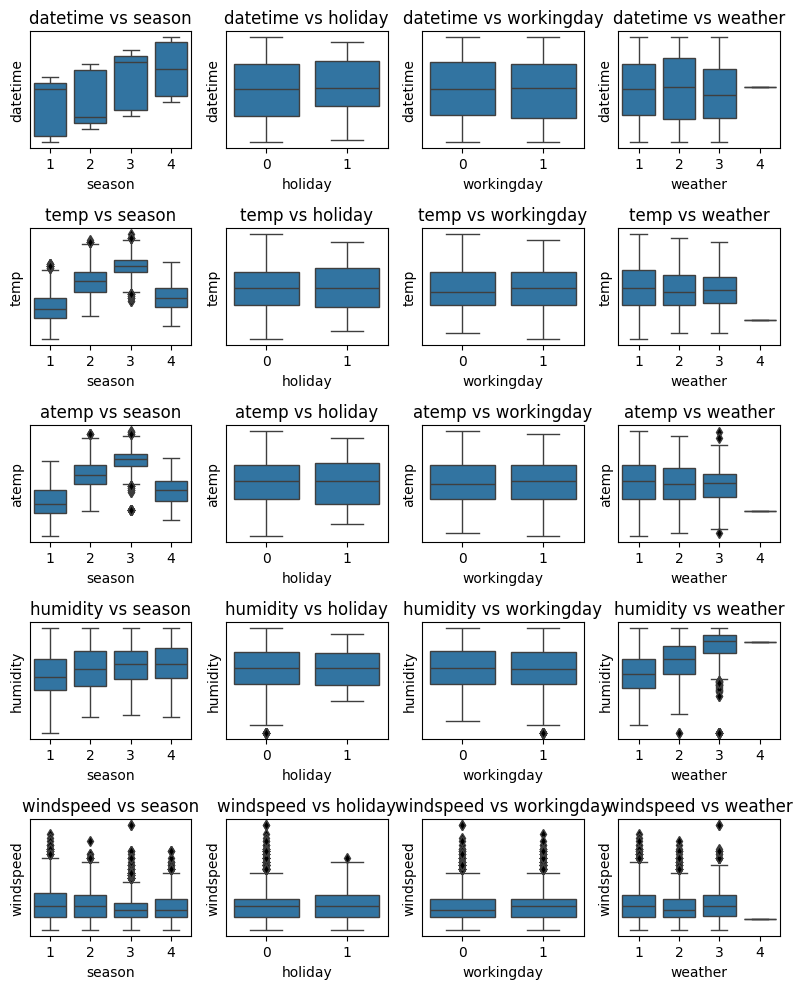

In [106]:
def plot_numerical_to_categorical(numerical_features, categorical_features, data):
    num_numerical = len(numerical_features)
    num_categorical = len(categorical_features)

    flierprops = dict(marker='d', markerfacecolor='black', markersize=5)
    
    fig, axes = plt.subplots(num_numerical, num_categorical, figsize=(
        8, 2 * num_numerical))

    for i, num_feature in enumerate(numerical_features):
        for j, cat_feature in enumerate(categorical_features):
            ax = axes[i, j] if num_numerical > 1 else axes[j]
            sns.boxplot(x=cat_feature, y=num_feature, data=data, ax=ax, flierprops=flierprops)
            ax.set_title(f'{num_feature} vs {cat_feature}')
            ax.set_yticklabels([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()


plot_numerical_to_categorical(numerical, categorical, train_data_transformed)

### Bivariate Analysis of Categorical - Categorical Features

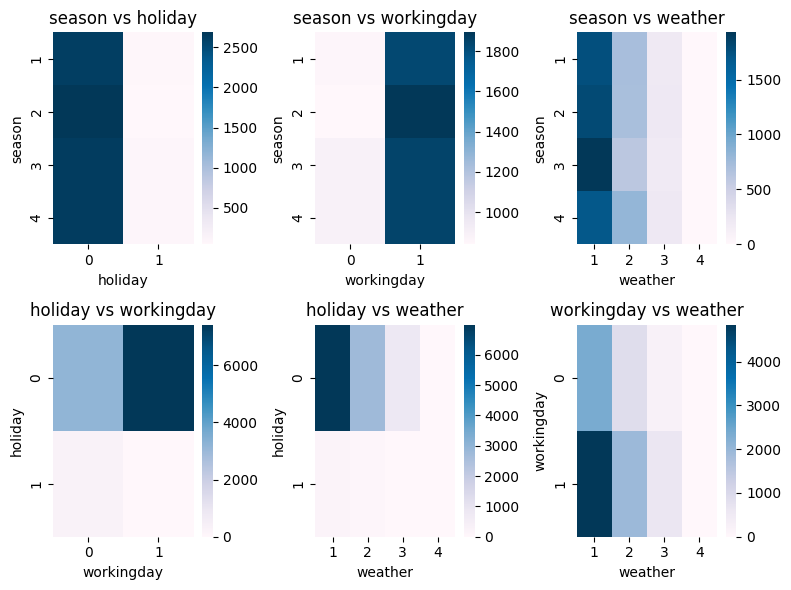

In [107]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes = axes.flatten()

pairs = [(categorical[x], categorical[y]) for x in range(len(categorical))
         for y in range(x + 1, len(categorical))]

for ax, (feature_i, feature_j) in zip(axes, pairs):
    crosstab = pd.crosstab(
        train_data_transformed[feature_i], train_data_transformed[feature_j])
    sns.heatmap(crosstab, cmap='PuBu', ax=ax,
                cbar=True, annot=False, fmt="d")
    ax.set_title(f'{feature_i} vs {feature_j}')

plt.tight_layout()
plt.show()

### Bivariate Analysis of Numerical Features - Target Variables

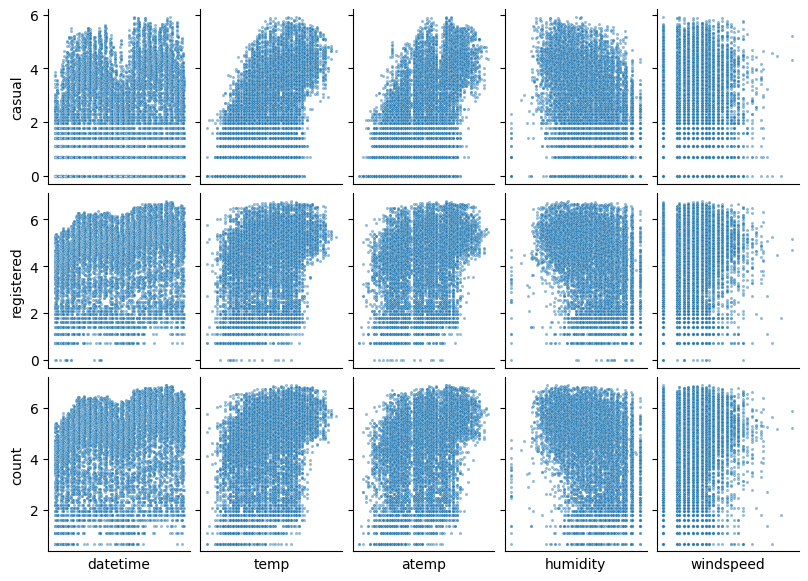

In [108]:
pairplot = sns.pairplot(data=train_data_transformed,
             x_vars=numerical,
             y_vars=TARGET_VARIABLES,
             kind='scatter',
                        plot_kws={'s': 5, 'alpha': 0.5})

pairplot.figure.set_size_inches(8, 6)

for ax in pairplot.axes.flatten():
    ax.set_xticklabels([])
    ax.set_xticks([])

plt.show()